In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from time import time
import gc
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
#path = '/Users/804357/Desktop/MyFiles/Learn/LOM/Data/'
path = '/Users/Vishy/Files/AVDatahack/LOM/Data/' 
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
camp = pd.read_csv(path+'campaign_data.csv')

In [3]:
print('New variable creations')
train['hour'] = pd.to_datetime(train.send_date).dt.hour.astype('uint8')
train['day'] = pd.to_datetime(train.send_date).dt.day.astype('uint8')
train['dow'] = pd.to_datetime(train.send_date).dt.dayofweek.astype('uint8')

test['hour'] = pd.to_datetime(test.send_date).dt.hour.astype('uint8')
test['day'] = pd.to_datetime(test.send_date).dt.day.astype('uint8')
test['dow'] = pd.to_datetime(test.send_date).dt.dayofweek.astype('uint8')

New variable creations


In [4]:
train.columns

Index(['id', 'user_id', 'campaign_id', 'send_date', 'is_open', 'is_click',
       'hour', 'day', 'dow'],
      dtype='object')

In [4]:
def overlap(list1,list2):
    listC = []
    for element in list1:
        if element in list2:
            listC.append(element)
    return len(listC)        
        
def distinct(list1,list2):
    listD = []
    for element in list1:
        if element not in list2:
            listD.append(element)
    return len(listD)        

In [5]:
print('The Number of unique users in Train and Test Data respectively are', train.user_id.nunique(), 
      test.user_id.nunique())
print('---------------------------------------------------------------')
print('The number of users from Train and in Test are:',len(set(train.user_id.unique())&set(test.user_id.unique())))
print('---------------------------------------------------------------')
print('The number of users from Train and not in Test are:',len(set(train.user_id.unique())^set(test.user_id.unique())))

The Number of unique users in Train and Test Data respectively are 168236 198219
---------------------------------------------------------------
The number of users from Train and in Test are: 145737
---------------------------------------------------------------
The number of users from Train and not in Test are: 74981


In [13]:
print('The Number of unique campaign in Train and Test Data respectively are', train.campaign_id.nunique(), 
      test.campaign_id.nunique())
print('----------------------------------------')
print('The number of campaigns from Train and in Test are:', len(set(train.campaign_id.unique())&set(train.campaign_id.unique())))
print('---------------------------------------------------------------')
print('The number of campaigns from Train and not in Test are:', len(set(train.campaign_id.unique())^set(test.campaign_id.unique())))

The Number of unique campaign in Train and Test Data respectively are 26 26
----------------------------------------
The number of campaigns from Train and in Test are: 26
---------------------------------------------------------------
The number of campaigns from Train and not in Test are: 52


In [14]:
print(train.campaign_id.nunique())
print(train.campaign_id.unique())
print(test.campaign_id.nunique())
print(test.campaign_id.unique())

26
[42 52 33 44 29 49 30 54 36 53 32 48 50 41 47 39 34 46 35 31 37 38 45 51
 40 43]
26
[63 56 57 71 76 74 67 75 64 69 78 79 61 58 77 60 80 65 70 55 68 73 59 66
 72 62]


In [16]:
train.is_open.value_counts()

0    920401
1    102790
Name: is_open, dtype: int64

In [17]:
train.is_click.value_counts()

0    1010409
1      12782
Name: is_click, dtype: int64

In [18]:
train.head()

,id,user_id,campaign_id,send_date,is_open,is_click,hour,day,dow
0,42_14051,14051,42,01-09-2017 19:55,0,0,19,9,0
1,52_134438,134438,52,02-11-2017 12:53,0,0,12,11,5
2,33_181789,181789,33,24-07-2017 15:15,0,0,15,24,0
3,44_231448,231448,44,05-09-2017 11:36,0,0,11,9,1
4,29_185580,185580,29,01-07-2017 18:01,0,0,18,7,5


In [2]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation
from collections import Counter
import re

In [5]:
def tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent

        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Error as e:
        print(e)

In [8]:
camp['sub_tokens'] = camp['subject'].map(tokenizer)

In [10]:
for subject, sub_tokens in zip(camp['subject'].head(5), camp['sub_tokens'].head(5)):
    print('subject:', subject)
    print('sub_tokens:', sub_tokens)
    print() 

subject: Sneak Peek: A look at the emerging data science world !
sub_tokens: ['sneak', 'peek', 'look', 'emerging', 'data', 'science', 'world']

subject: [July] Data Science Expert Meetups & Competitions coming your way
sub_tokens: ['july', 'data', 'science', 'expert', 'meetups', 'competitions', 'coming', 'way']

subject: Last chance to convince your boss before the Early Bird expires !
sub_tokens: ['last', 'chance', 'convince', 'boss', 'early', 'bird', 'expires']

subject: A.I. & Machine Learning: 5 reasons why you should attend DataHack Summit 2017
sub_tokens: ['a.i', 'machine', 'learning', 'reasons', 'attend', 'datahack', 'summit']

subject: [Delhi NCR] Fireside Chat with DJ Patil, Former US Chief Data Scientist
sub_tokens: ['delhi', 'ncr', 'fireside', 'chat', 'dj', 'patil', 'former', 'us', 'chief', 'data', 'scientist']



In [11]:
camp['email_tokens'] = camp['email_body'].map(tokenizer)

In [12]:
for email_body, email_tokens in zip(camp['email_body'].head(5), camp['email_tokens'].head(5)):
    print('email_body:', email_body)
    print('email_tokens:', email_tokens)
    print() 

email_body: Dear AVians,
 
We are shaping up a superb data science ecosystem brick by brick. The community is thriving with events and interactions. I can see a new world where data science knowledge is getting created through our community interactions.
 
Our entire team extremely excited about our first annual conference - DataHack Summit 2017. The conference is shaping up superbly - this would be first of its kind conference with hands-on practitioners sharing their knowledge, challenges and bleeding edge work. A few awesome sessions & workshops have been announced and there are many more to come. Book your early-bird spot before they finish. If you know/are a data science leader and have done really awesome work - reach out to us and we can provide you Indias largest platform for data science practitioners.
 
Now, coming to last month, I am feeling proud to announce that our dedicated volunteers now run meet up programs across 5 cities - check out our upcoming Expert Meet-ups. The

In [19]:
train_df = pd.merge(train, camp, on='campaign_id')
test_df = pd.merge(test, camp, on='campaign_id')
print('Shape of the train data is', train_df.shape)
print('Shape of the test data is', test_df.shape)

Shape of the train data is (1023191, 19)
Shape of the test data is (773858, 17)


In [20]:
print(train_df.communication_type.nunique())
print(train_df.communication_type.unique())
print(test_df.communication_type.nunique())
print(test_df.communication_type.unique())

7
['Newsletter' 'Others' 'Upcoming Events' 'Conference' 'Corporate'
 'Hackathon' 'Webinar']
4
['Newsletter' 'Upcoming Events' 'Hackathon' 'Corporate']


In [22]:
test_df.head()

,id,campaign_id,user_id,send_date,hour,day,dow,communication_type,total_links,no_of_internal_links,no_of_images,no_of_sections,email_body,subject,email_url,sub_tokens,email_tokens
0,63_122715,63,122715,01-02-2018 22:35,22,2,1,Newsletter,68,64,15,5,\r\nFebruary 2018 Newsletter\r\n \r\nDear AVia...,"AVbytes, Ultimate 2018 learning path and aweso...",http://r.newsletters.analyticsvidhya.com/7whsu...,"[avbytes, ultimate, learning, path, awesome, c...","[february, newsletter, dear, avian, couldnt, ..."
1,63_124394,63,124394,01-02-2018 22:47,22,2,1,Newsletter,68,64,15,5,\r\nFebruary 2018 Newsletter\r\n \r\nDear AVia...,"AVbytes, Ultimate 2018 learning path and aweso...",http://r.newsletters.analyticsvidhya.com/7whsu...,"[avbytes, ultimate, learning, path, awesome, c...","[february, newsletter, dear, avian, couldnt, ..."
2,63_95168,63,95168,01-02-2018 22:44,22,2,1,Newsletter,68,64,15,5,\r\nFebruary 2018 Newsletter\r\n \r\nDear AVia...,"AVbytes, Ultimate 2018 learning path and aweso...",http://r.newsletters.analyticsvidhya.com/7whsu...,"[avbytes, ultimate, learning, path, awesome, c...","[february, newsletter, dear, avian, couldnt, ..."
3,63_31556,63,31556,01-02-2018 23:09,23,2,1,Newsletter,68,64,15,5,\r\nFebruary 2018 Newsletter\r\n \r\nDear AVia...,"AVbytes, Ultimate 2018 learning path and aweso...",http://r.newsletters.analyticsvidhya.com/7whsu...,"[avbytes, ultimate, learning, path, awesome, c...","[february, newsletter, dear, avian, couldnt, ..."
4,63_138377,63,138377,01-02-2018 22:48,22,2,1,Newsletter,68,64,15,5,\r\nFebruary 2018 Newsletter\r\n \r\nDear AVia...,"AVbytes, Ultimate 2018 learning path and aweso...",http://r.newsletters.analyticsvidhya.com/7whsu...,"[avbytes, ultimate, learning, path, awesome, c...","[february, newsletter, dear, avian, couldnt, ..."


In [23]:
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

# Restart from here

In [2]:
path = '/Users/Vishy/Files/AVDatahack/LOM/Data/'
train_df = pd.read_csv(path+'train_df.csv')
test_df = pd.read_csv(path+'test_df.csv')

In [3]:
train_df.communication_type.value_counts()

Newsletter         451053
Conference         332633
Upcoming Events    148964
Others              50936
Hackathon           33265
Webinar              3487
Corporate            2853
Name: communication_type, dtype: int64

In [4]:
test_df.communication_type.value_counts()

Upcoming Events    302125
Newsletter         291706
Hackathon          144667
Corporate           35360
Name: communication_type, dtype: int64

In [ ]:
traindf

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

vectorizer = TfidfVectorizer(min_df=10, max_features=10000, ngram_range=(1, 2))#tokenizer=tokenizer,
vz = vectorizer.fit_transform(list(train_df['sub_tokens']))

In [28]:
vz.shape

(1023191, 254)

In [29]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

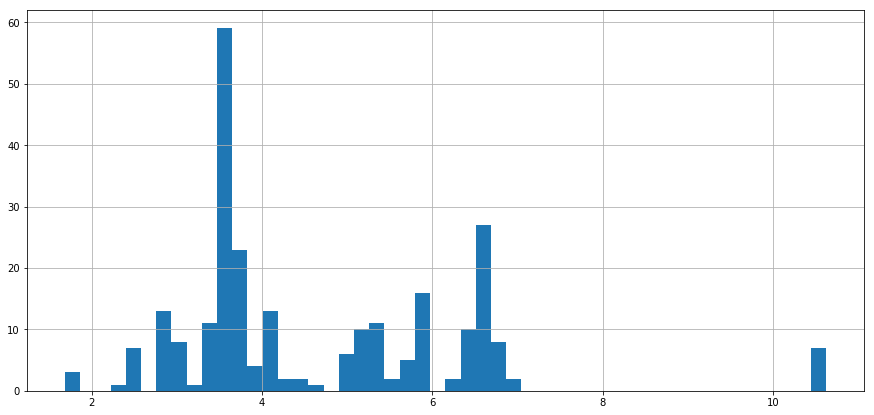

In [30]:
import matplotlib.pyplot as plt
tfidf.tfidf.hist(bins=50, figsize=(15,7))
plt.show()

In [31]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(20)

,tfidf
datahack,1.686195
datahack summit,1.686195
summit,1.686195
data,2.304260
hackathons,2.423032
machine learning,2.444907
learning,2.444907
machine,2.444907
data science,2.489196
science,2.489196


In [32]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
grow,10.618930
innovate,10.618930
innovate grow,10.618930
business data,10.618930
business,10.618930
data hackathons,10.618930
grow business,10.618930
participate datahack,6.905717
participate,6.905717
last chance,6.769722


In [33]:
vz = vectorizer.fit_transform(list(train_df['email_tokens']))

In [34]:
vz.shape

(1023191, 2764)

In [35]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

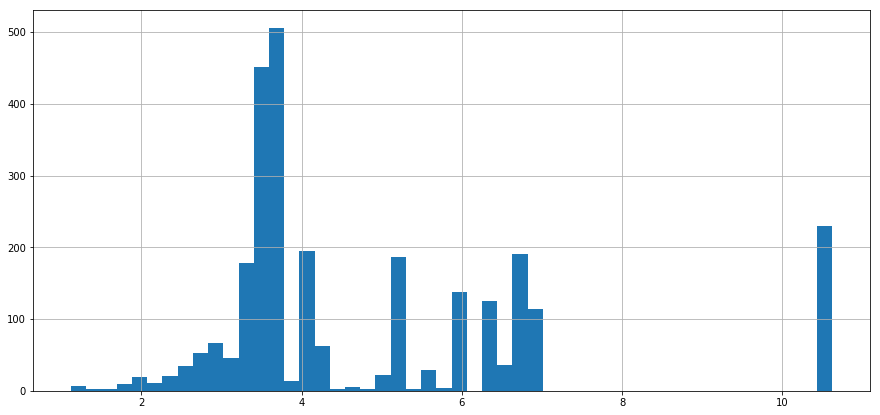

In [36]:
import matplotlib.pyplot as plt
tfidf.tfidf.hist(bins=50, figsize=(15,7))
plt.show()

In [37]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(20)

,tfidf
science,1.122753
data,1.122753
data science,1.122753
summit,1.196789
datahack summit,1.196789
datahack,1.196789
dear,1.269956
learning,1.323015
coming,1.400166
conference,1.439765


In [38]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
world elevate,10.61893
talent,10.61893
hackathons let,10.61893
hackathons showcase,10.61893
logistics optimization,10.61893
talented data,10.61893
talented,10.61893
talent augment,10.61893
organisations create,10.61893
apps,10.61893


In [40]:
path = '/Users/Vishy/Files/AVDatahack/LOM/Data/' 
camp = pd.read_csv(path+'campaign_data.csv')

In [41]:
camp = camp.head(5)

In [52]:
camp

,campaign_id,communication_type,total_links,no_of_internal_links,no_of_images,no_of_sections,email_body,subject,email_url
0,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...
1,30,Upcoming Events,18,14,7,1,"Dear AVians,\r\n \r\nAre your eager to know wh...",[July] Data Science Expert Meetups & Competiti...,http://r.newsletters.analyticsvidhya.com/7up0e...
2,31,Conference,15,13,5,1,Early Bird Pricing Till August 07  Save upto ...,Last chance to convince your boss before the E...,http://r.newsletters.analyticsvidhya.com/7usym...
3,32,Conference,24,19,7,1,\r\n \r\nHi ?\r\n \r\nBefore I dive into why y...,A.I. & Machine Learning: 5 reasons why you sho...,http://r.newsletters.analyticsvidhya.com/7uthl...
4,33,Others,7,3,1,1,Fireside Chat with DJ Patil - the master is he...,"[Delhi NCR] Fireside Chat with DJ Patil, Forme...",http://r.newsletters.analyticsvidhya.com/7uvlg...


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

vectorizer1 = TfidfVectorizer(min_df=2, max_features=10000, ngram_range=(1, 2), tokenizer=tokenizer,)
tf = vectorizer1.fit_transform(list(camp['subject']))

In [71]:
tf.shape

(5, 3)

In [72]:
tfidf = dict(zip(vectorizer1.get_feature_names(), vectorizer1.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [73]:
tfidf

,tfidf
data,1.405465
data science,1.693147
science,1.693147


In [74]:
vectorizer2 = TfidfVectorizer(min_df=2, max_features=10000, ngram_range=(1, 2), binary=True, tokenizer=tokenizer,)#
tf1 = vectorizer2.fit_transform(list(camp['subject']))

In [75]:
tf1.shape

(5, 3)

In [76]:
tfidf = dict(zip(vectorizer2.get_feature_names(), vectorizer2.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [77]:
tfidf

,tfidf
data,1.405465
data science,1.693147
science,1.693147


In [78]:
vectorizer3 = TfidfVectorizer(min_df=2, max_features=10000, ngram_range=(1, 2), binary=True, tokenizer=tokenizer,use_idf=False)#
tf2 = vectorizer3.fit_transform(list(camp['subject']))

In [79]:
tf2.shape

(5, 3)

In [80]:
tfidf = dict(zip(vectorizer3.get_feature_names(), vectorizer3.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

AttributeError: 'TfidfTransformer' object has no attribute '_idf_diag'

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer4 = CountVectorizer(min_df=2, max_features=10000, ngram_range=(1, 2))
tf4 = vectorizer4.fit_transform(list(camp['subject']))

In [85]:
tf4.shape

(5, 5)

In [88]:
vectorizer4.get_feature_names()

['data', 'data science', 'science', 'the', 'your']